### Importing libraries and initializing dataframes

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import openai
from sentence_transformers import SentenceTransformer, util
import json
import os
import sys
import glob
from tqdm import tqdm
import argparse
from pathlib import Path
from tenacity import retry, stop_after_attempt, wait_random_exponential
import multiprocessing as mp
model = SentenceTransformer('all-MiniLM-L6-v2')

openai.api_key = ''


df = pd.read_csv(r'qualitative_annotations_translations.csv')
# dataframe with all restaurants w CH names
CH_df = df.dropna(subset=['Chinese_Name'])
CH_df = CH_df.reset_index(drop = True)
# rural restaurants w CH names
CH_rural_df = df[df['Area'].isin([1])]
CH_rural_df = CH_rural_df.dropna(subset=['Chinese_Name'])
# print(CH_rural_df)
CH_rural_df = CH_rural_df.reset_index(drop = True)
# urban restaurants w CH names
CH_urban_df = df[df['Area'].isin([0])]
CH_urban_df = CH_urban_df.dropna(subset=['Chinese_Name'])
CH_urban_df = CH_urban_df.reset_index(drop = True)
# print(CH_urban_df)

c:\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# res = str(list(CH_rural_df['Chinese_Name']))
# print(res)
# # print(CH_df)
# Ch = pd.concat([CH_rural_df,CH_urban_df])
# Ch = Ch.reset_index(drop = True)
# Ch.to_csv("merged.csv", encoding='utf-8')

### Pipelining

In [ ]:
# step 1. Use chatgpt to translate the name into english

# this function prompts a response (translation) from chatGPT
def get_translation(prompt, model="gpt-4"):

    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
    model=model,
    messages=messages,
    temperature=0,
    )
    return response.choices[0].message["content"]

# this function does chatGPT translation for a given dataframe, key name, and csv file name to write to
def add_translations(key,data):
    restaurant_list = str(list(data[key]))
    prompt =  "Here is a list of rules to translate Chinese restaurant names to English:"+\
     "1. Translate each name character by character. Some examples:"+\
        "'江东楼' 'River East House'"+\
        "'满福轩' 'Full Luck Pavillion'"+\
        "'锦煌' “Golden Splendor'"+\
        "'六婆串串香' 'Six Auntie Skewers Fragrant'"+\
    "2. Only return the english translations and don't return the Chinese names. No explanation needed. "+\
    "3. If a character or a phrase has a Chinese meaning and doesn’t look like a person’s name, return the literal translation of this character or phrase instead of the Romanized version and please pay special attention to this."+\
    "4. Make sure there’s as little Romanization in the translations as possible. Here are some examples for your reference. For instance,"+\
        "'翠苑海鲜酒楼' 'Emerald Garden Seafood Restaurant'"+\
        "'湘遇' 'Xiang Meet'"+\
        "'嘉嘉海鲜菜馆' “Gaga Seafood Restaurant”"+\
        "'素素小食' “Su Su Snacks”\n"+\
        "Make sure to refer to these examples when you do the translation."+\
    "Give me the literal english translations of the Chinese restaurant names" + restaurant_list[1:len(restaurant_list)-1] + "Only return the english translations and don't return the Chinese names. No explanation needed.Return all the English translations in the form of a python list."

    response = get_translation(prompt)
    res = response.strip('][').split(', ')
    res = [ele[1:len(ele)-1] for ele in res]
#     print(res)
    data["chatGPT_translation"] = res
    print(data["chatGPT_translation"])
    return data
#     data.to_csv(filename, encoding='utf-8')

# def main():
#     parser = argparse.ArgumentParser()
# #     parser.add_argument("--input_file", type=str, default="./data/law/LEDGAR_sample.csv")
# #     parser.add_argument("--audience", default="lay people", type=str)
#     parser.add_argument("--prompt_file_path", default="threading_df.csv", type=str)
# #     parser.add_argument("--output_folder", type=str, default="./outputs/law/simple/")
# #     parser.add_argument("--model", default="gpt-4", type=str)
#     parser.add_argument("--key",default = 'Chinese_Name',type = str)
#     parser.add_argument("--dataframe") #, type = pandas.core.frame.DataFrame
#     parser.add_argument("--batch_num", default = 2, type = int)
#     args = parser.parse_args()
def main(filename, key, dataframe, batch_num):
    # calling the API in parallel ################################################
    pool = mp.Pool()

    responses = []
    for df in tqdm(np.array_split(dataframe, batch_num)):
        response = pool.apply_async(add_translations, (key, df)) #response = 
        responses.append(response.get())
#     dfs = []
#     for df in tqdm(responses):
#         dfs.append(df)
    results = pd.concat(responses)
    results = results.reset_index(drop = True)
    results.to_csv(filename, encoding='utf-8')

    pool.close()
    pool.join()

main("testing_parallel.csv","Chinese_Name",CH_df, 2)  
# if __name__ == "__main__":
#     parser.parse_args("")
#     main()

# creating urban and rural chatgpt translations
# add_translations("Chinese_Name",CH_rural_df)
# add_translations("Chinese_Name",CH_urban_df)
# add_translations("Chinese_Name",CH_df)


### testing get_translation
# prompt = "give me the literal english translations of the Chinese restaurant names 味鼎, 翠苑海鲜酒楼, 撩香米线, 江东楼, 素素小食, 湘遇, 福城, 华明, 满福轩, 常熟, 锦煌, 藤王馔, 烹小鲜, 素描湘, 六婆串串香. Translate each name character by character. Return all the English translations in a python list. Only return the english translations and don't return the Chinese names. No explanation needed. As long as a character or a phrase has a Chinese meaning and doesn’t look like a person’s name, return the literal translation of this character or phrase instead of the Romanized version and please pay special attention to this. Make sure there’s as little Romanization in the translations as possible."
# "give me the literal english translations of the Chinese restaurant names 味鼎, 翠苑海鲜酒楼, 撩香米线, 江东楼, 素素小食, 湘遇, 福城, 华明, 满福轩, 常熟, 锦煌, 藤王馔, 烹小鲜, 素描湘, 六婆串串香. Return all the English translations in a python list. Only return the english translations and don't return the Chinese names. No explanation needed. As long as a character or a phrase has a Chinese meaning and doesn’t look like a person’s name, return the literal translation of this character or phrase instead of the Romanized version and please pay special attention to this. Make sure there’s as little Romanization in the translations as possible."
# "give me the literal english translations of the Chinese restaurant names 味鼎, 翠苑海鲜酒楼, 撩香米线, 江东楼, 素素小食, 湘遇, 福城, 华明, 满福轩, 常熟, 锦煌, 藤王馔, 烹小鲜, 素描湘, 六婆串串香. Only return the english translations and don't return the Chinese names. Return all the translations in a list. No explanation needed. If a character or a phrase has a Chinese meaning and doesn’t look like a person’s name, return the literal translation of this character or phrase instead of the Romanized version. For instance, 江东楼 should be translated as River East House and 锦煌 should be translated as Golden Splendor. 满福轩 should be translated as Full Luck Pavillion while 素素小食 should be Su Su Snacks. Only use Romanization if there are no other alternative translations and please pay special attention to this. Make sure there’s as little Romanization in the translations as possible. Don’t use Romanization on characters or phrases that have actual meanings in Chinese unless it is obviously a person’s name. Imagine you are a professional translator and you’re translating this for a bilingual audience who speaks both English and Chinese fluently."
# "give me the literal english translations of the Chinese restaurant names 味鼎, 翠苑海鲜酒楼, 撩香米线, 江东楼, 素素小食, 湘遇, 福城, 华明, 满福轩, 常熟, 锦煌, 藤王馔, 烹小鲜, 素描湘, 六婆串串香. Return all the translations in a list. Only return the english translations and don't return the Chinese names. No explanation needed. As long as a character or a phrase has a Chinese meaning and doesn’t look like a person’s name, return the literal translation of this character or phrase instead of the Romanized version and please pay special attention to this. Make sure there’s as little Romanization in the translations as possible. For restaurant names that contain people’s names, return the Romanized version of the names and translate the rest."
# print(get_translation(prompt))


  0%|                                                                                                                              | 0/2 [00:00<?, ?it/s]

In [ ]:


_BATCH_SIZE = 5

def run_gpt4_query(filled_prompt):
    response = openai.ChatCompletion.create(
        model="gpt-4",
        messages=[
            {"role": "system", "content": "You are a helpful translator who does Chinese-English translation. You were"+\
            "born in a Chinese-American family so you know both cultures very well."},
            {"role": "user", "content": filled_prompt},
        ],
        temperature=0,
    )
    return response

@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def get_text_explanation(text, audience, prompt_file):
    """returns a list of translations
    
    Args:
        restaurants: a string containing a list of Chinese names of Chinese restaurants

    Returns:
        str: a string containing a list of English translations of the Chinese names

    """
    # Read prompt template
    prompt_template = open(prompt_file).read()

    prompt = prompt_template.replace("%TEXT%", text)
    prompt = prompt.replace("%AUDIENCE%", audience)
    prompt = prompt.strip("\n").strip()
    prompt = prompt + "\n\n"
    response = run_gpt4_query(prompt)
    print(prompt)
    response = response["choices"][0]['message']['content'].strip("\n")
    return response

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument("--input_file", type=str, default="./data/law/LEDGAR_sample.csv")
    parser.add_argument("--audience", default="lay people", type=str)
    parser.add_argument("--prompt_file_path", default="./prompts/explain.txt", type=str)
    parser.add_argument("--output_folder", type=str, default="./outputs/law/simple/")
    parser.add_argument("--model", default="gpt-4", type=str)
    args = parser.parse_args()

#     df_text = pd.read_csv(args.input_file, delimiter="\t")
#     df_text = df_text.iloc[:50]
#     print(df_text.shape)
#     output_folder = args.output_folder

#     Path(output_folder).mkdir(parents=True, exist_ok=True)

    # map audience to its full string
#     short_prompt = "ETT {}".format(args.audience) # Explain this to (ETT)
#     audience_folder = "_".join(short_prompt.split())
#     Path(os.path.join(output_folder, audience_folder)).mkdir(parents=True, exist_ok=True)

    # calling the API in parallel ################################################
    pool = mp.Pool()

    responses = []
    for text_id, text in tqdm(zip(df_text.ID.to_list(), df_text.text.to_list())):
        response = pool.apply_async(get_text_explanation, (text, args.audience, args.prompt_file_path))
        responses.append([text_id, text, response])

    for text_id, text, response in tqdm(responses):
        json_obj = {"id": text_id, "text": text}
        json_obj["explanation"] = response.get()
        json_obj = json.dumps(json_obj, indent=4)
        with open(os.path.join(output_folder, audience_folder, "{}.json".format(text_id)), "w", encoding='UTF-8') as out:
            out.write(json_obj)

    pool.close()
    pool.join()

if __name__ == "__main__":
    main()

In [4]:
print(CH_urban_df["Area"])


0     0
1     0
2     0
3     0
4     0
     ..
83    0
84    0
85    0
86    0
87    0
Name: Area, Length: 88, dtype: int64


### Computing Semantic Similarities between english names and chatgpt translations

In [5]:


# Two lists of sentences
def semantic_compare(data, filename, key1 = "English_Name", key2 = "chatGPT_translation"):
    
    names1 = data[key1] #"English_Name"

    names2 = data[key2] #chatGPT_translation
#     print("names1 dtype", names1.dtypes)

    #Compute embedding for both lists
    embeddings1 = model.encode(names1, convert_to_tensor=True)
    embeddings2 = model.encode(names2, convert_to_tensor=True)

    #Compute cosine-similarities
    cosine_scores = util.cos_sim(embeddings1, embeddings2)
    scores = []
    #Output the pairs with their score
    for i in range(len(names1)):
        cos = cosine_scores[i][i]
        scores.append("{:.4f}".format(cos))
    #     print("{} \t\t {} \t\t Score: {:.4f}".format(names1[i], names2[i], cos))
    data["embedding_similarity"] = scores
    data.to_csv(filename, encoding='utf-8')
    data['embedding_similarity'] = pd.to_numeric(data['embedding_similarity'], downcast='float')
    print("Naming semantics similarity:",data["embedding_similarity"].mean())

semantic_compare(CH_rural_df,"rural_embedding_translation.csv")
semantic_compare(CH_urban_df,"urban_embedding_translation.csv")
semantic_compare(CH_df,"general_embedding_translation.csv")

# semantic_compare(CH_df,"rural_embedding_translation_literal.csv",key2 = "Literal_Translation")
# semantic_compare(CH_urban_df,"urban_embedding_translation_literal.csv",key2 = "Literal_Translation")

Naming semantics similarity: 0.58555835
Naming semantics similarity: 0.42268407
Naming semantics similarity: 0.43876407


In [6]:
print(CH_df['embedding_similarity'].tolist())

[0.7893000245094299, 0.49970000982284546, 0.22370000183582306, 0.19949999451637268, 0.4487999975681305, 0.24199999868869781, 0.1460999995470047, 0.5273000001907349, 0.3601999878883362, 0.19339999556541443, 0.3061000108718872, 0.5521000027656555, 0.10939999669790268, 0.3061000108718872, 0.5037000179290771, 0.49950000643730164, 0.34360000491142273, 0.34599998593330383, 0.6259999871253967, 0.1688999980688095, 0.050599999725818634, 0.7939000129699707, 0.8267999887466431, 0.7422999739646912, 0.1386999934911728, 1.0, 0.09399999678134918, 0.4779999852180481, 0.11400000005960464, 1.0, 0.11540000140666962, 0.2459000051021576, 0.1559000015258789, 0.8507999777793884, 0.4018999934196472, 0.6897000074386597, 0.10100000351667404, 0.2468000054359436, 0.30079999566078186, 0.14190000295639038, 0.12430000305175781, 0.6172999739646912, 0.1454000025987625, 0.774399995803833, 0.3666999936103821, 0.798799991607666, 0.7577000260353088, 0.2506999969482422, 0.6086999773979187, 0.15049999952316284, 0.9207999706

### Evaluating text similarities with BERTScore

In [7]:
from bert_score import score
from pprint import pprint
from torchmetrics.text.bert import BERTScore
# When you are running this cell for the first time, 
# it will download the BERT model which will take relatively longer. 
# P, R, F1 = score(cands, refs, lang="en", verbose=True)
# print(f"System level F1 score: {F1.mean():.3f}")

def BERT_compare(data, key1 = "English_Name", key2 = "chatGPT_translation"):
    
    names1 = data[key1].tolist() #"English_Name"

    names2 = data[key2].tolist() #chatGPT_translation
  
    bertscore = BERTScore()
    # printing F1 scores
    scores = bertscore(names1, names2)
    F1 = scores['f1'].tolist()
    precision = scores['precision'].tolist()
    recall = scores['recall'].tolist()
    data['BERT_F1'] = F1
    data['BERT_precision'] = precision
    data['BERT_recall'] = recall
    # printing mean F1 scores and all the other scores
#     print(f"System level F1 score: {F1.mean():.3f}")
#     pprint(bertscore(names1, names2))
    
BERT_compare(CH_df)
print(CH_df)
# !pip install torchmetrics
# from pprint import pprint
# from torchmetrics.text.bert import BERTScore
# preds = ["hello there", "general kenobi"]
# target = ["hello there", "master kenobi"]
# bertscore = BERTScore()
# pprint(bertscore(preds, target))



c:\python38\lib\site-packages\torchmetrics\utilities\prints.py:42: UserWarning: The argument `model_name_or_path` was not specified while it is required when the default `transformers` model is used. It will use the default recommended model - 'roberta-large'.
  warnings.warn(*args, **kwargs)  # noqa: B028
Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights o

    Unnamed: 0  Unnamed: 0.1  Unnamed: 0.1.1  index  \
0            0             0               0      0   
1            1             1               1      1   
2            2             2               2      2   
3            3             3               3      3   
4            4             4               4      4   
..         ...           ...             ...    ...   
95          95            95              95    115   
96          96            96              96    120   
97          97            97              97    123   
98          98            98              98    124   
99          99            99              99    129   

                            English_Name Chinese_Name  \
0                       Shanghai Cuisine         上海小馆   
1                         Shanghai Fresh          十八鲜   
2                           Kao Barbecue         久经烤焰   
3                           Taiwan Cafe           海之味   
4                         Hunan Cuisine          异国他湘 

In [8]:
# CH_df.to_csv("Transformer_BERT_scores.csv", encoding='utf-8')

### Correlation Analysis

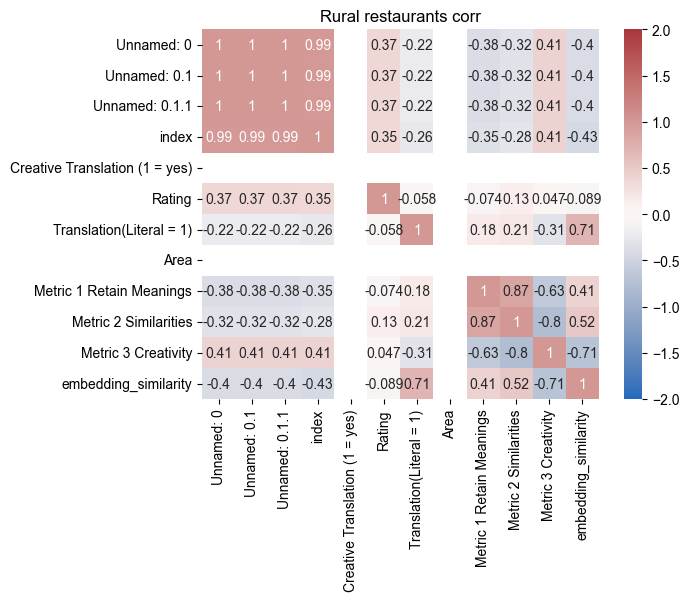

<Figure size 1500x600 with 0 Axes>

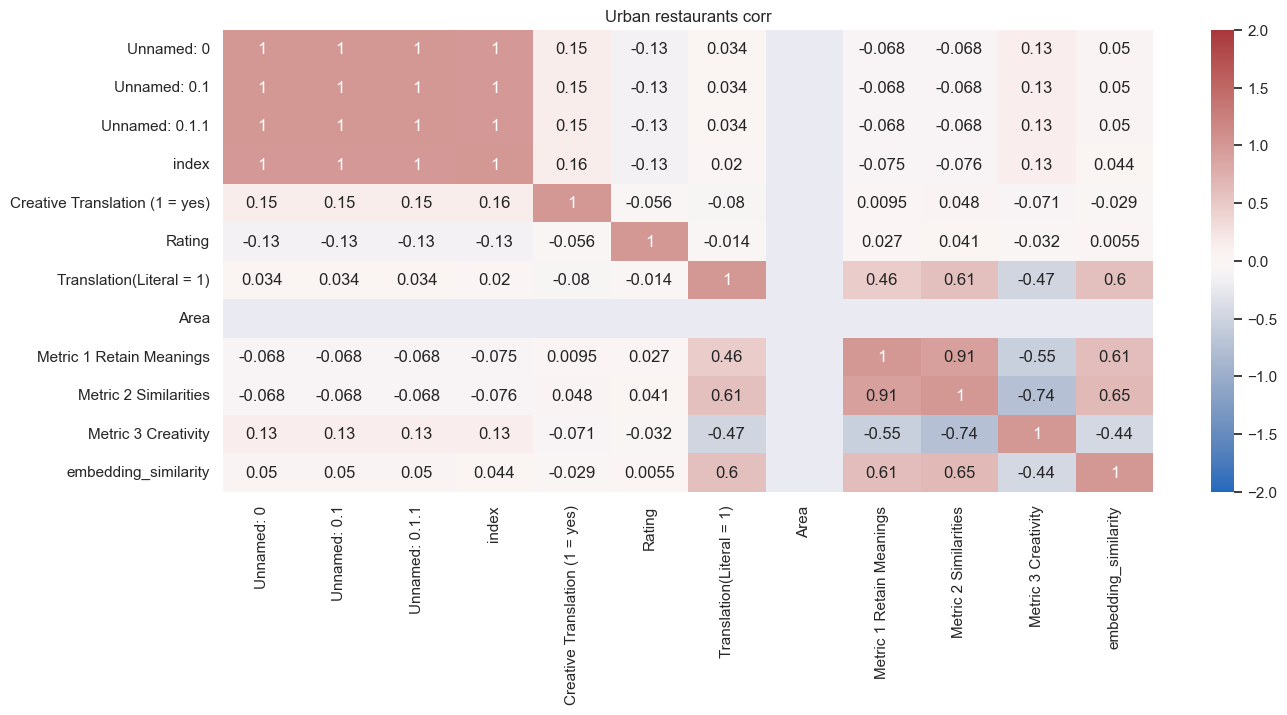

<Figure size 1500x600 with 0 Axes>

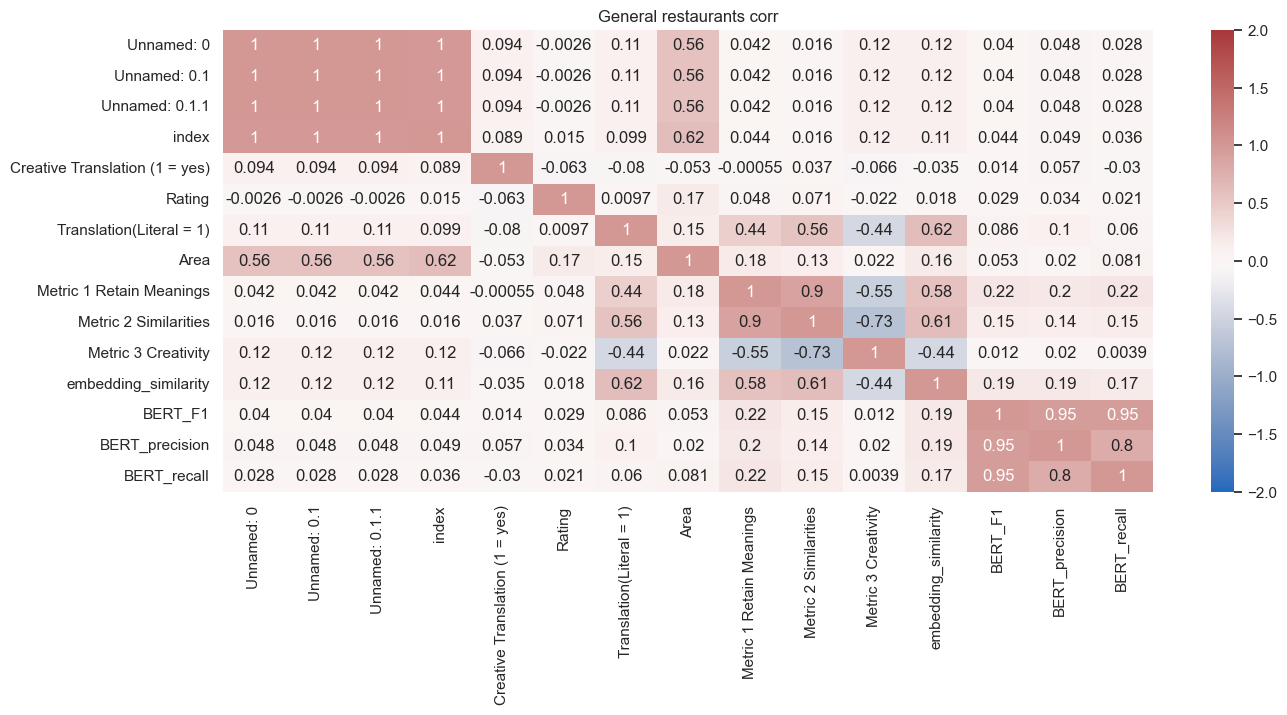

<Figure size 1500x600 with 0 Axes>

In [9]:
def corr_analysis(data,filename,title):
    matrix = data.corr()
# #     rs = np.random.RandomState(0)
# #     df = pd.DataFrame(rs.rand(10, 10))
# #     corr = df.corr()
#     matrix.style.background_gradient(cmap='coolwarm')
    sns.heatmap(matrix, annot=True, vmax=2, vmin=-2, center=0, cmap='vlag')
    sns.set (rc = {'figure.figsize':(15, 6)})
    plt.title(title)
    matrix.style.background_gradient(cmap='coolwarm', axis=None)
    plt.figure(figsize=(15, 6))
#     figure.set_size_inches(20, 12) 
    plt.savefig(filename)
    plt.show()
corr_analysis(CH_rural_df,"rural_corr.png","Rural restaurants corr")
corr_analysis(CH_urban_df,"urban_corr.png","Urban restaurants corr")
corr_analysis(CH_df,"General_corr.png","General restaurants corr")

### Authentic Vs. Inauthentic Restaurant Rating Comparison

authentic 4.133333333333334
inauthentic 4.0465909090909085
general 4.054639175257732


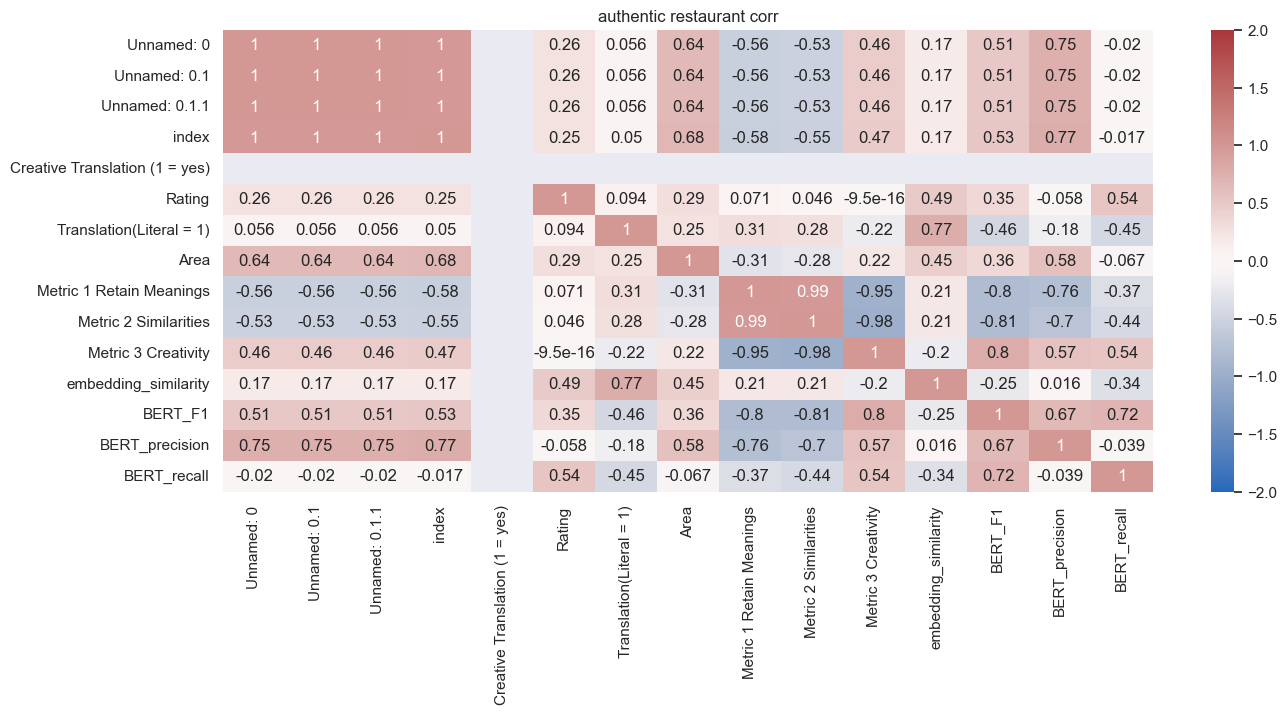

<Figure size 1500x600 with 0 Axes>

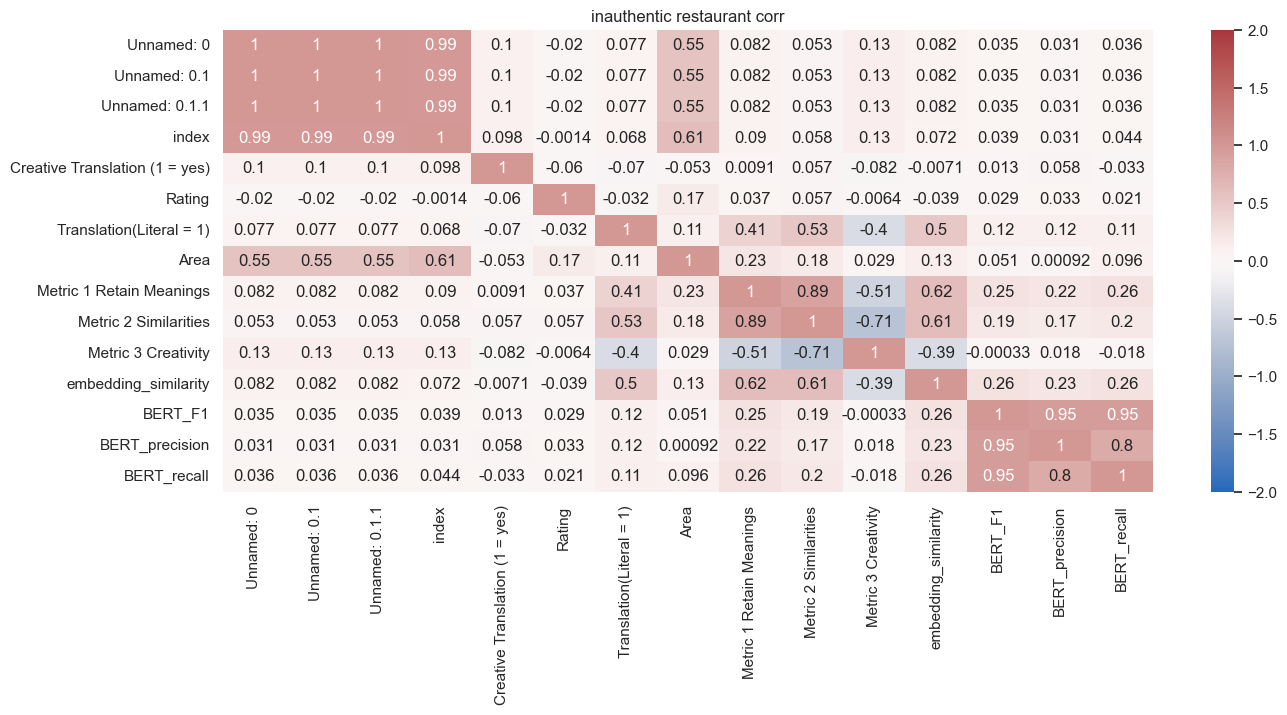

<Figure size 1500x600 with 0 Axes>

In [10]:
authentic_df = CH_df[CH_df['embedding_similarity']>= 0.8]
inauthentic_df = CH_df[CH_df['embedding_similarity']< 0.8]
authentic_mean = authentic_df['Rating'].mean(axis=0)
inauthentic_mean = inauthentic_df['Rating'].mean(axis=0)
general_mean = CH_df['Rating'].mean(axis=0)
print("authentic",authentic_mean)
print("inauthentic",inauthentic_mean)
# print(authentic_df)
print("general",general_mean)

corr_analysis(authentic_df,"authentic_df.png","authentic restaurant corr")
corr_analysis(inauthentic_df,"inauthentic_df.png","inauthentic restaurant corr")

############ results ########################
# authentic 4.133333333333334
# inauthentic 4.0465909090909085
# general 4.054639175257732

### Linear Regression Model

0.033575752472428895 0.1969720578137361


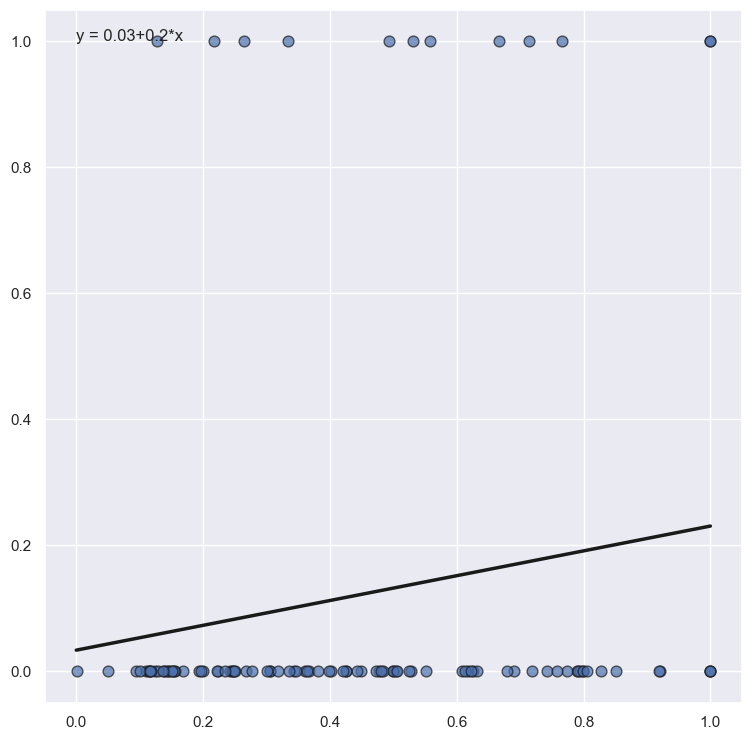

In [11]:
# Linear relationship
# Generate data
# rng = np.random.default_rng(1234)
# x = rng.uniform(0, 10, size=100)
# y = x + rng.normal(size=100)
def plot_linear(df1, df2):
    # Initialize layout
    fig, ax = plt.subplots(figsize = (9, 9))

    # Add scatterplot
    ax.scatter(df1, df2, s=60, alpha=0.7, edgecolors="k")

    # Fit linear regression via least squares with numpy.polyfit
    # It returns an slope (b) and intercept (a)
    # deg=1 means linear fit (i.e. polynomial of degree 1)
    b1,b0= np.polyfit(df1, df2, deg=1)
    print(b0,b1)
    # Create sequence of 100 numbers from 0 to 100 
    xseq = np.linspace(0, 1, num=100)

    # Plot regression line
    ax.plot(xseq, b0 + b1 * xseq, color="k", lw=2.5);
    ax.text(0, 1, 'y = ' + str(round(b0,2)) + '+' + str(round(b1,2))+'*x')
# plot_linear(CH_df["embedding_similarity"], CH_df["Metric 1 Retain Meanings"])
plot_linear(CH_df["embedding_similarity"], CH_df["Area"])